In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

import sys
import os
import time

code_dir = os.path.join(os.getcwd(), '..')
config_dir = os.path.join(code_dir, '..', 'config')
sys.path.append(code_dir)

from data.query_data import get_data
from forecaster.bayesian_linear_forecaster import BayesianLinearForecaster

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Amazon specific pre-processing here

In [3]:
config_file_path = os.path.join(config_dir, '2018EU.json')
data = get_data(config_file_path=config_file_path)

fee_change_date = pd.to_datetime('02-21-2018')  # Fee change went into effect on this date
fee_announce_date = pd.to_datetime('12-21-2017')  # Fee change went into effect on this date

In [4]:
data = data.drop('marketplace_id', axis=1)
data['platform'] = data['platform'].str.lower()

In [5]:
daily_data = data.groupby(['pg_rollup', 'order_day', 'gl_product_group',
                           'platform'], as_index=False)[['quant_sold']].sum()
daily_data['order_day'] = pd.to_datetime(daily_data['order_day'])

In [6]:
target_platform = 'fba'
topline = daily_data[daily_data['platform'] == 'fba']
topline = topline.drop('platform', axis=1)

In [7]:
topline_counts = topline.groupby(['pg_rollup', 'gl_product_group']).sum().sort_values(['pg_rollup', 'quant_sold'], ascending=False)

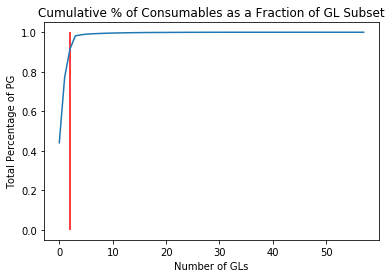

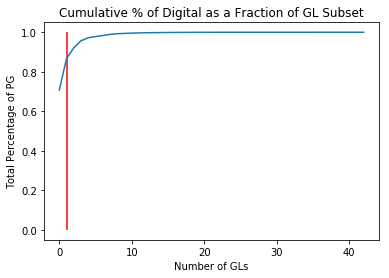

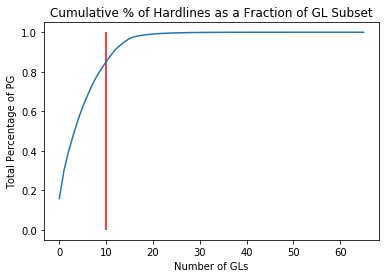

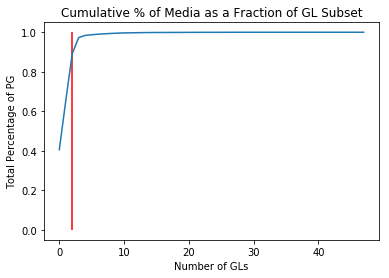

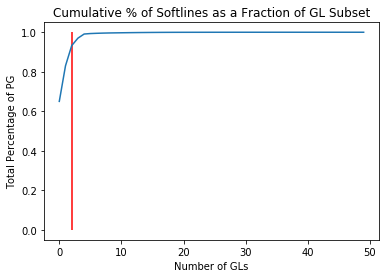

In [8]:
included_pg = {}
excluded_pg = {}

for pg in topline_counts.index.levels[0]:
    pg_counts = topline_counts.loc[pg, :]
    topline_cumulative_percent = pg_counts / pg_counts.sum()
    pg_cumulative = np.cumsum(topline_cumulative_percent['quant_sold'])
    
    cutoff = np.searchsorted(pg_cumulative, 0.85)[0]
    
    included_pg[pg] = pg_cumulative.iloc[:cutoff+1].index
    excluded_pg[pg] = pg_cumulative.iloc[cutoff+1:].index
    
    plt.figure()
    plt.plot(range(len(topline_cumulative_percent)), pg_cumulative)
    plt.xlabel('Number of GLs')
    plt.ylabel('Total Percentage of PG')
    plt.title('Cumulative % of {} as a Fraction of GL Subset'.format(pg))
    plt.vlines(cutoff, 0, 1, 'r')

# Targets

This consists of the topline (ie, the sum of all GL)

In [9]:
# this is the topline:
target_df = [topline.groupby('order_day').sum()['quant_sold'].sort_index()]
col_names = ['y0']
hierarchy = {'pg_rollup': {'y0': []}, 'gl': {}}

for pg in included_pg:
    pg_col_name = 'y_{}'.format(pg)
    hierarchy['gl'][pg_col_name] = []
    pg_topline = topline[topline['pg_rollup'] == pg]
    
    target_df.append(pg_topline.groupby('order_day').sum()['quant_sold'].sort_index())
    col_names.append(pg_col_name)
    hierarchy['pg_rollup']['y0'].append(pg_col_name)
    
    for gl in included_pg[pg]:
        gl_col_name = 'y_{}_{}'.format(pg, int(gl))
        gl_topline = pg_topline[pg_topline['gl_product_group'] == gl]
        
        target_df.append(gl_topline.groupby('order_day').sum()['quant_sold'].sort_index())
        col_names.append(gl_col_name)
        hierarchy['gl'][pg_col_name].append(gl_col_name)
    
    # remaining GL
    remaining_gl_topline = pg_topline[pg_topline['gl_product_group'].isin(included_pg[pg]) == 0]
    remaining_col_name = 'y_{}_{}'.format(pg, 'unk')
    
    target_df.append(remaining_gl_topline.groupby('order_day').sum()['quant_sold'].sort_index())
    col_names.append(remaining_col_name)
    hierarchy['gl'][pg_col_name].append(remaining_col_name)

target_df = pd.concat(target_df, axis=1, keys=col_names)
assert (target_df.sum().sum() == target_df['y0'].sum()*3)
target_df['t'] = target_df.index

In [10]:
features_df = daily_data[daily_data['platform'] != 'fba']
features_df = features_df.groupby(['gl_product_group', 'platform', 'order_day']).sum()
features_df = features_df.sort_values('order_day')
features_df = features_df.unstack([0, 1])
features_df = features_df.dropna(axis=1)

col_names = []
for i in range(len(features_df.columns)):
    platform = features_df.columns.get_level_values(1)[i]
    gl = features_df.columns.get_level_values(2)[i]
    col_names.append("{}_{}".format(platform, gl))

features_df.columns = col_names

In [11]:
pg_and_gl_df = pd.concat([target_df, features_df], axis=1)

# Map estimate of model with full covariance

In [12]:
pg_and_gl_forecaster = BayesianLinearForecaster(pg_and_gl_df, t0=fee_change_date, pca_features=False,
                                                feature_selection_method='elastic_net',
                                                mcmc_covariance_estimation_method='OAS',
                                                hierarchy=hierarchy, full_covariance=True,
                                                estimate_reconciliation_sigma=False, 
                                                reconcile_forecast=False)

pg_and_gl_forecaster._build_model(sigma_prior_scale=0.1, beta_prior_scale=0.25)
model = pg_and_gl_forecaster.model_

We are fitting the following observations: 
train_obs


In [13]:
advi_cov_model = pm.ADVI(model=model)

tracker = pm.callbacks.Tracker(
    mean=advi_cov_model.approx.mean.eval,  # callable that returns mean
    std=advi_cov_model.approx.std.eval  # callable that returns std
)

approx = advi_cov_model.fit(200000, callbacks=[tracker])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Average Loss = -1.4238e+05: 100%|██████████| 200000/200000 [52:23<00:00, 63.63it/s]
Finished [100%]: Average Loss = -1.424e+05


In [ ]:
fig = plt.figure(figsize=(16, 9))

mu_ax = fig.add_subplot(221)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')

std_ax = fig.add_subplot(222)
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')

hist_ax = fig.add_subplot(212)
hist_ax.plot(advi_cov_model.hist)
hist_ax.set_title('Negative ELBO track');

In [15]:
traces = approx.sample(1000)
pg_and_gl_forecaster.map_estimate_ = None
pg_and_gl_forecaster.trace_ = traces

pg_and_gl_forecaster.plot_fit()

Problem occurred during compilation with the command line below:
/home/ubuntu/anaconda3/bin/g++ -shared -g -O3 -fno-math-errno -Wno-unused-label -Wno-unused-variable -Wno-write-strings -march=broadwell -mmmx -mno-3dnow -msse -msse2 -msse3 -mssse3 -mno-sse4a -mcx16 -msahf -mmovbe -maes -mno-sha -mpclmul -mpopcnt -mabm -mno-lwp -mfma -mno-fma4 -mno-xop -mbmi -mno-sgx -mbmi2 -mno-tbm -mavx -mavx2 -msse4.2 -msse4.1 -mlzcnt -mno-rtm -mno-hle -mrdrnd -mf16c -mfsgsbase -mno-rdseed -mno-prfchw -mno-adx -mfxsr -mxsave -mxsaveopt -mno-avx512f -mno-avx512er -mno-avx512cd -mno-avx512pf -mno-prefetchwt1 -mno-clflushopt -mno-xsavec -mno-xsaves -mno-avx512dq -mno-avx512bw -mno-avx512vl -mno-avx512ifma -mno-avx512vbmi -mno-avx5124fmaps -mno-avx5124vnniw -mno-clwb -mno-mwaitx -mno-clzero -mno-pku -mno-rdpid --param l1-cache-size=32 --param l1-cache-line-size=64 --param l2-cache-size=46080 -mtune=broadwell -DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -m64 -fPIC -I/home/ubuntu/anaconda3/lib/python3.6/site

OSError: [Errno 12] Cannot allocate memory

In [ ]:
forecast = pg_and_gl_forecaster.output_df_

In [ ]:
means = pd.concat([forecast[col_name].mean(axis=1) for col_name in pg_and_gl_forecaster.target_columns],
                  axis=1, keys=pg_and_gl_forecaster.target_columns)

In [ ]:
means.to_csv('python_recon.csv')

In [327]:
#### import packages
import pandas
import numpy
import rpy2
import rpy2.robjects as robjects
from  rpy2.robjects import r as R
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
hts =  rpackages.importr('hts')
ggplot =  rpackages.importr('ggplot2')
datatable =  rpackages.importr('data.table')

In [228]:
pandas2ri.activate()

In [333]:
### import file
indep = pandas.read_csv('/home/ubuntu/data/python_indep.csv')
indep['algo']= 'no_rec'
indep.rename(columns={'Unnamed: 0':'dates'}, inplace=True)
colnms = indep.drop(['algo','dates','y0','y_Consumables','y_Digital','y_Hardlines','y_Media','y_Softlines'], axis=1).columns.values

input  = indep[['y0', 'y_Consumables', 'y_Digital', 'y_Hardlines' , 'y_Media', 'y_Softlines',
                          'y_Consumables_121', 'y_Consumables_194', 'y_Consumables_325', 'y_Consumables_unk',
                          'y_Digital_400', 'y_Digital_425', 'y_Digital_unk',
                          'y_Hardlines_107', 'y_Hardlines_147', 'y_Hardlines_200', 'y_Hardlines_201', 'y_Hardlines_21','y_Hardlines_229',
                          'y_Hardlines_23', 'y_Hardlines_468', 'y_Hardlines_60', 'y_Hardlines_79', 'y_Hardlines_86', 'y_Hardlines_unk',
                          'y_Media_14', 'y_Media_63', 'y_Media_74', 'y_Media_unk',
                          'y_Softlines_193', 'y_Softlines_197', 'y_Softlines_309', 'y_Softlines_unk']]


In [337]:
from  rpy2.robjects import vectors as vec
nodes = [5,[4,3,12,4,4]]

In [360]:
 nodes[1]

[4, 3, 12, 4, 4]

In [361]:
pi = robjects.r['pi']

In [358]:
#nodes = robjects.r('''nodes <- list(5, c(4,3,12,4,4))''')

#input_r =  pandas2ri.py2ri(input)
nodes = rpy2.robjects.StrVector(nodes[0], nodes[1])
#[nodes[i] for i in enumerate(nodes)]

TypeError: __init__() takes 2 positional arguments but 3 were given

In [341]:
output = []
algo = numpy.array(["lu", "cg", "chol", "recursive"])
input_r =  pandas2ri.py2ri(input)
for i in range(len(algo)):
    recon_r = pandas.DataFrame(numpy.matrix(hts.combinef(input, nodes, algorithms = algo[i])[0]))
    recon_r.columns = colnms
    recon_r['algo']= algo[i]
    recon_r['dates']= indep['dates']
    if i == 0:
        output = recon_r
    else :
        output = output.append(recon_r)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in sum(xlist[[length(xlist)]]) : invalid 'type' (list) of argument

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error in sum(xlist[[length(xlist)]]) : invalid 'type' (list) of argument


In [241]:
output

,y_Consumables_121,y_Consumables_194,y_Consumables_325,y_Consumables_unk,y_Digital_400,y_Digital_425,y_Digital_unk,y_Hardlines_107,y_Hardlines_147,y_Hardlines_200,...,y_Media_14,y_Media_63,y_Media_74,y_Media_unk,y_Softlines_193,y_Softlines_197,y_Softlines_309,y_Softlines_unk,algo,dates
0,9.289832e+05,6.866817e+05,287168.899077,167926.249393,7492.801619,17838.692024,9299.355142,9.653015e+05,4.557569e+05,4.308693e+05,...,67141.022776,52304.163937,40831.682500,19883.156000,8.223035e+05,112647.274782,223639.395581,84337.531109,lu,2018-02-22
1,8.390974e+05,6.268694e+05,262454.874498,152516.555272,5633.364090,16011.947646,7424.838083,8.914951e+05,4.054740e+05,3.819864e+05,...,54603.321796,50905.927054,38057.250061,17410.586798,7.513962e+05,110907.788499,197600.811687,77184.009807,lu,2018-02-23
2,8.040051e+05,6.461176e+05,262820.899994,156823.968078,6602.045884,17200.808189,8468.333017,8.720712e+05,3.352953e+05,3.904708e+05,...,45750.540724,50270.652089,36906.791139,15971.060076,7.473176e+05,112153.849706,204759.464819,78700.236074,lu,2018-02-24
3,9.201734e+05,7.391531e+05,305259.103294,184531.929331,8679.642484,19168.998754,10627.589935,9.845617e+05,3.678165e+05,4.644544e+05,...,56035.676685,53127.769160,41686.945915,20238.218432,8.786694e+05,124530.530315,248027.677115,88266.125406,lu,2018-02-25
4,9.763904e+05,7.255137e+05,317444.732341,185541.444691,10651.617618,20939.830583,12625.087363,1.013403e+06,4.646561e+05,4.675599e+05,...,72300.898108,57717.982400,45765.167391,24522.133554,8.625835e+05,119235.150488,249167.286005,93440.196946,lu,2018-02-26
5,9.298806e+05,6.958419e+05,306417.518449,175077.643883,9175.175021,20167.811521,11104.263217,9.642850e+05,4.553509e+05,4.433973e+05,...,69858.508695,56007.022062,43040.500796,22329.987415,8.245329e+05,115450.394587,233777.877616,89742.233566,lu,2018-02-27
6,9.614535e+05,7.207460e+05,316014.431122,176882.618055,8143.570241,18745.122575,10064.308503,9.796114e+05,4.624620e+05,4.526987e+05,...,70486.876829,54281.767032,42979.422255,22178.966439,8.489144e+05,119622.323121,238811.846411,88381.600370,lu,2018-02-28
7,9.144350e+05,6.794796e+05,303626.446310,163348.247689,5175.023362,15750.310744,7198.525287,9.506370e+05,4.479706e+05,4.312454e+05,...,64903.591358,50958.795347,38955.604987,18476.660987,8.336492e+05,119883.406448,220144.893482,83856.960971,lu,2018-03-01
8,8.335385e+05,6.277677e+05,274583.373382,147851.563608,2007.954330,12721.815199,3898.885173,8.903733e+05,4.068479e+05,3.862783e+05,...,54349.111052,46995.318733,34515.389752,13338.860188,7.744216e+05,116877.970858,191552.043478,74931.926014,lu,2018-03-02
9,7.998565e+05,6.475996e+05,270395.132415,157778.252406,4398.498844,14779.300949,6332.071808,8.574589e+05,3.365692e+05,3.920190e+05,...,44393.123191,47413.664145,33776.866858,13809.245435,7.696682e+05,116708.574198,199572.318035,76331.705281,lu,2018-03-03


In [120]:
x = R('''

pp <- ggplot() + 
   geom_line(data = output[algo == "lu"], aes(x = dates, y = y_Hardlines_229 , group = 1), col = "red") +
  geom_line(data = fcst_no_rec[algo == "no_rec"], aes(x = dates, y = y_Hardlines_229 , group = 1), col = "black") +
  ggtitle(paste0("individual vs reconciled : ", "y0") ) +
  theme(plot.title = element_text(size = 20, face = "bold", hjust = 0.5) , axis.text=element_text(size=10,face="bold"),
        axis.title=element_text(size=12,face="bold") , 
        legend.text = element_text(colour="blue", size=10, 
                                   face="bold")) +
  scale_color_discrete(name = "ltitle") +
  scale_x_discrete(breaks=c("2018-02-01","2018-03-01","2018-04-01","2018-05-01","2018-06-01", "2018-07-01"))
  ggsave('/home/ubuntu/output.jpeg', plot = pp)
''')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in combinef(input, nodes, algorithms = m) : 
  object 'input' not found

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error in combinef(input, nodes, algorithms = m) : 
  object 'input' not found


In [323]:
import os
os.environ['R_HOME'] = '/home/ubuntu/anaconda3/lib/R'

#### import packages
import pandas
import numpy
import rpy2
import rpy2.robjects as robjects
from  rpy2.robjects import r as R
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import rpy2.robjects.packages as rpackages
hts =  rpackages.importr('hts')

### import file
indep = pandas.read_csv('/home/ubuntu/data/python_indep.csv')
indep.rename(columns={'Unnamed: 0':'dates'}, inplace=True)

###defines columns with right names
input  = pandas.DataFrame(indep[['y0', 'y_Consumables', 'y_Digital', 'y_Hardlines' , 'y_Media', 'y_Softlines',
                          'y_Consumables_121', 'y_Consumables_194', 'y_Consumables_325', 'y_Consumables_unk',
                          'y_Digital_400', 'y_Digital_425', 'y_Digital_unk',
                          'y_Hardlines_107', 'y_Hardlines_147', 'y_Hardlines_200', 'y_Hardlines_201', 'y_Hardlines_21','y_Hardlines_229',
                          'y_Hardlines_23', 'y_Hardlines_468', 'y_Hardlines_60', 'y_Hardlines_79', 'y_Hardlines_86', 'y_Hardlines_unk',
                          'y_Media_14', 'y_Media_63', 'y_Media_74', 'y_Media_unk',
                          'y_Softlines_193', 'y_Softlines_197', 'y_Softlines_309', 'y_Softlines_unk']])

##### copies column names to rename the output of combinef
colnms = input.columns.values

#### defines nodes
nodes = robjects.r('''nodes <- list(5, c(4,3,12,4,4))''')

output = []
algo = numpy.array(["lu", "cg", "chol", "recursive"])
for i in range(len(algo)):
    recon_r = pandas.DataFrame(numpy.matrix(hts.allts(hts.combinef(input, nodes, algorithms = algo[i]))))
    recon_r.columns = colnms
    recon_r = pandas.concat([recon_r, pandas.DataFrame(indep['dates'])], axis = 1)
    recon_r['algo']= algo[i]
   
    if i == 0:
        output = recon_r
    else :
        output = output.append(recon_r)


        

In [324]:
output

,y0,y_Consumables,y_Digital,y_Hardlines,y_Media,y_Softlines,y_Consumables_121,y_Consumables_194,y_Consumables_325,y_Consumables_unk,...,y_Media_14,y_Media_63,y_Media_74,y_Media_unk,y_Softlines_193,y_Softlines_197,y_Softlines_309,y_Softlines_unk,dates,algo
0,9.770474e+06,2.070760e+06,34630.848785,6.241995e+06,180160.025212,1.242928e+06,9.289832e+05,6.866817e+05,287168.899077,167926.249393,...,67141.022776,52304.163937,40831.682500,19883.156000,8.223035e+05,112647.274782,223639.395581,84337.531109,2018-02-22,lu
1,8.844432e+06,1.880938e+06,29070.149819,5.636357e+06,160977.085709,1.137089e+06,8.390974e+05,6.268694e+05,262454.874498,152516.555272,...,54603.321796,50905.927054,38057.250061,17410.586798,7.513962e+05,110907.788499,197600.811687,77184.009807,2018-02-23,lu
2,8.650237e+06,1.869768e+06,32271.187089,5.456368e+06,148899.044029,1.142931e+06,8.040051e+05,6.461176e+05,262820.899994,156823.968078,...,45750.540724,50270.652089,36906.791139,15971.060076,7.473176e+05,112153.849706,204759.464819,78700.236074,2018-02-24,lu
3,1.003852e+07,2.149118e+06,38476.231173,6.340344e+06,171088.610192,1.339494e+06,9.201734e+05,7.391531e+05,305259.103294,184531.929331,...,56035.676685,53127.769160,41686.945915,20238.218432,8.786694e+05,124530.530315,248027.677115,88266.125406,2018-02-25,lu
4,1.043437e+07,2.204890e+06,44216.535564,6.660526e+06,200306.181452,1.324426e+06,9.763904e+05,7.255137e+05,317444.732341,185541.444691,...,72300.898108,57717.982400,45765.167391,24522.133554,8.625835e+05,119235.150488,249167.286005,93440.196946,2018-02-26,lu
5,9.972149e+06,2.107218e+06,40447.249759,6.369745e+06,191236.018968,1.263503e+06,9.298806e+05,6.958419e+05,306417.518449,175077.643883,...,69858.508695,56007.022062,43040.500796,22329.987415,8.245329e+05,115450.394587,233777.877616,89742.233566,2018-02-27,lu
6,1.021128e+07,2.175096e+06,36953.001319,6.513574e+06,189927.032555,1.295730e+06,9.614535e+05,7.207460e+05,316014.431122,176882.618055,...,70486.876829,54281.767032,42979.422255,22178.966439,8.489144e+05,119622.323121,238811.846411,88381.600370,2018-02-28,lu
7,9.757570e+06,2.060889e+06,28123.859393,6.237728e+06,173294.652679,1.257534e+06,9.144350e+05,6.794796e+05,303626.446310,163348.247689,...,64903.591358,50958.795347,38955.604987,18476.660987,8.336492e+05,119883.406448,220144.893482,83856.960971,2018-03-01,lu
8,8.916719e+06,1.883741e+06,18628.654702,5.707367e+06,149198.679724,1.157783e+06,8.335385e+05,6.277677e+05,274583.373382,147851.563608,...,54349.111052,46995.318733,34515.389752,13338.860188,7.744216e+05,116877.970858,191552.043478,74931.926014,2018-03-02,lu
9,8.697560e+06,1.875630e+06,25509.871601,5.494746e+06,139392.899629,1.162281e+06,7.998565e+05,6.475996e+05,270395.132415,157778.252406,...,44393.123191,47413.664145,33776.866858,13809.245435,7.696682e+05,116708.574198,199572.318035,76331.705281,2018-03-03,lu


In [99]:
x = R('''fcst_no_rec<- fread(('python_indep.csv'))[,algo:="no_rec"]
colnames(fcst_no_rec)[which(colnames(fcst_no_rec) == "V1")] = "dates"
colnms<- fcst_no_rec[,-c("algo","dates","y0", "y_Consumables", "y_Digital","y_Hardlines","y_Media","y_Softlines")]
colnms<- colnames(colnms)

input<-fcst_no_rec[,list( y0, y_Consumables, y_Digital, y_Hardlines , y_Media, y_Softlines,
                          y_Consumables_121, y_Consumables_194, y_Consumables_325, y_Consumables_unk,
                          y_Digital_400, y_Digital_425, y_Digital_unk,
                          y_Hardlines_107, y_Hardlines_147, y_Hardlines_200, y_Hardlines_201, y_Hardlines_21,y_Hardlines_229,
                          y_Hardlines_23, y_Hardlines_468, y_Hardlines_60, y_Hardlines_79, y_Hardlines_86, y_Hardlines_unk,
                          y_Media_14, y_Media_63, y_Media_74, y_Media_unk,
                          y_Softlines_193, y_Softlines_197, y_Softlines_309, y_Softlines_unk)]
nodes <- list(5, c(4,3,12,4,4))
output<-list()
algs = c("lu", "cg", "chol", "recursive")''')
x = R('''i = 1
for (m in algs){
  output[[i]] <-  data.table(combinef(input,nodes, algorithms = m)$bts)
  output[[i]][,c("algo","dates") := list(m,fcst_no_rec$dates)]
  i = i + 1
}

output<- rbindlist(output)
colnames(output)<- c(colnms, "algo","dates")

pp <- ggplot() + 
   geom_line(data = output[algo == "lu"], aes(x = dates, y = y_Hardlines_229 , group = 1), col = "red") +
  geom_line(data = fcst_no_rec[algo == "no_rec"], aes(x = dates, y = y_Hardlines_229 , group = 1), col = "black") +
  ggtitle(paste0("individual vs reconciled : ", "y0") ) +
  theme(plot.title = element_text(size = 20, face = "bold", hjust = 0.5) , axis.text=element_text(size=10,face="bold"),
        axis.title=element_text(size=12,face="bold") , 
        legend.text = element_text(colour="blue", size=10, 
                                   face="bold")) +
  scale_color_discrete(name = "ltitle") +
  scale_x_discrete(breaks=c("2018-02-01","2018-03-01","2018-04-01","2018-05-01","2018-06-01", "2018-07-01"))
  ggsave('/home/ubuntu/output.jpeg', plot = pp)
''')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)
